# Jena Dataset Temperature Forecast

**TODO**: Add description

In [1]:
import warnings
from pathlib import Path

import optuna
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

2023-02-02 12:07:45.599876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 12:07:47.659427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 12:07:47.660034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-02 12:07:47.660057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
DATA_ROOT = Path('data')

## Data Loading

In [3]:
data_df = pd.read_csv(DATA_ROOT / 'jena_climate_2009_2016.csv', parse_dates=['Date Time'], infer_datetime_format=True,  na_values=['-9999.0'], index_col='Date Time').resample(rule='10T').mean()
data_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Feature engineering

In [4]:
data_df['lag_1d'] = data_df['T (degC)'].shift(1 * 6 * 24)
data_df['lag_30d'] = data_df['T (degC)'].shift(30 * 6 * 24)

In [5]:
data_df.dropna(inplace=True)

## Data splitting

To proper make a data spliting in this dataset, we need to consider temporality of the data. Thus, instead of using classical percentage-based spliting, we used a time spliting. For our validation and test sets we selected 1-year time window in the end of the timeseries for each set.

In [6]:
train_df = data_df.loc['2009-01-01':'2014-12-31']
val_df = data_df.loc['2015-01-01':'2015-12-31']
test_df = data_df.loc['2016-01-01':'2016-12-31']

print(f'Train set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Train set size: 310886
Validation set size: 52540
Test set size: 51670


## Model training

In [7]:
feature_columns = ['VPmax (mbar)', 'rho (g/m**3)', 'lag_1d', 'lag_30d']
target_column = 'T (degC)'

## Model search with Optuna

### Random Forest Regressor

In [12]:
rf_study = optuna.create_study(direction='minimize')

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
    }
    model = RandomForestRegressor(**params)
    model.fit(train_df[feature_columns], train_df[target_column])
    return (val_df[target_column] - model.predict(val_df[feature_columns])).abs().mean()

rf_study.optimize(objective, n_trials=10)

rf_model = RandomForestRegressor(**rf_study.best_params)

rf_model.fit(train_df[feature_columns], train_df[target_column])

[I 2023-02-02 15:10:27,490] A new study created in memory with name: no-name-ae4bfd0c-8596-4d10-a0ea-2f1337c233f1
[I 2023-02-02 15:13:59,042] Trial 0 finished with value: 0.005428260512964294 and parameters: {'n_estimators': 430, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto'}. Best is trial 0 with value: 0.005428260512964294.
[I 2023-02-02 15:14:51,105] Trial 1 finished with value: 0.05687046785942175 and parameters: {'n_estimators': 135, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'auto'}. Best is trial 0 with value: 0.005428260512964294.
[I 2023-02-02 15:17:55,027] Trial 2 finished with value: 0.6020097278143011 and parameters: {'n_estimators': 803, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto'}. Best is trial 0 with value: 0.005428260512964294.
[I 2023-02-02 15:20:03,017] Trial 3 finished with value: 0.17022146787110523 and parameters: {'n_estimators': 542, 'max_depth'

RandomForestRegressor(max_depth=9, max_features='auto', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=345)

### SVM Regressor

In [9]:
svr_study = optuna.create_study(direction='minimize')

def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 100),
        'epsilon': trial.suggest_float('epsilon', 0.1, 100),
        'gamma': trial.suggest_float('gamma', 0.1, 100),
    }
    model = SVR(**params)
    model.fit(train_df[feature_columns], train_df[target_column])
    return (val_df[target_column] - model.predict(val_df[feature_columns])).abs().mean()

svr_study.optimize(objective, n_trials=10)

svr_model = SVR(**svr_study.best_params)

[I 2023-02-01 11:41:36,406] A new study created in memory with name: no-name-f3296a22-7d2a-45f5-8261-e1733494a40f
[I 2023-02-01 14:31:07,750] Trial 0 finished with value: 6.556225277688637 and parameters: {'C': 71.1336683077332, 'epsilon': 19.364548361325397, 'gamma': 59.71996162503764}. Best is trial 0 with value: 6.556225277688637.
[I 2023-02-01 14:31:08,092] Trial 1 finished with value: 6.942566044918158 and parameters: {'C': 56.79192453268997, 'epsilon': 45.72600780658144, 'gamma': 83.74246196100486}. Best is trial 0 with value: 6.556225277688637.
[I 2023-02-01 18:21:53,564] Trial 2 finished with value: 6.3680590597219515 and parameters: {'C': 22.029064915313093, 'epsilon': 2.137456772886827, 'gamma': 86.4547476398151}. Best is trial 2 with value: 6.3680590597219515.
[I 2023-02-01 18:22:21,853] Trial 3 finished with value: 6.706413860968242 and parameters: {'C': 8.056494789996469, 'epsilon': 25.10576840349376, 'gamma': 76.63092276213088}. Best is trial 2 with value: 6.3680590597219

In [14]:
svr_model.fit(train_df[feature_columns], train_df[target_column])

SVR(C=22.029064915313093, epsilon=2.137456772886827, gamma=86.4547476398151)

In [13]:
svr_model = SVR(kernel='rbf', C=0.1, gamma=0.1)
svr_model.fit(train_df[feature_columns], train_df[target_column])

SVR(C=0.1, gamma=0.1)

### XGBoost Regressor

In [14]:
xgb_study = optuna.create_study(direction='minimize')

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(train_df[feature_columns], train_df[target_column])
    return (val_df[target_column] - model.predict(val_df[feature_columns])).abs().mean()

xgb_study.optimize(objective, n_trials=10)

xgb_model = xgb.XGBRegressor(**xgb_study.best_params)

xgb_model.fit(train_df[feature_columns], train_df[target_column])

[I 2023-02-02 18:07:19,895] A new study created in memory with name: no-name-145943b9-4537-4e5d-acbe-b2feaeaba082
[I 2023-02-02 18:07:38,547] Trial 0 finished with value: 0.22029356305321512 and parameters: {'n_estimators': 246, 'max_depth': 4, 'learning_rate': 0.030936385559962698, 'subsample': 0.5119122413074642, 'colsample_bytree': 0.818459009557796}. Best is trial 0 with value: 0.22029356305321512.
[I 2023-02-02 18:08:09,804] Trial 1 finished with value: 0.05499093301547399 and parameters: {'n_estimators': 443, 'max_depth': 4, 'learning_rate': 0.09232364330032265, 'subsample': 0.6587240819914318, 'colsample_bytree': 0.7907251533868114}. Best is trial 1 with value: 0.05499093301547399.
[I 2023-02-02 18:08:30,615] Trial 2 finished with value: 0.5690666129275949 and parameters: {'n_estimators': 163, 'max_depth': 8, 'learning_rate': 0.025340639648687456, 'subsample': 0.5292376536703216, 'colsample_bytree': 0.7123001777664149}. Best is trial 1 with value: 0.05499093301547399.
[I 2023-02

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8630814535169004, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06260427843359179,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=848, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Recurrent Neural Network

In [10]:
lstm_study = optuna.create_study(direction='minimize')

def objective(trial):
    params = {
        'units': trial.suggest_int('units', 8, 32),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
    }
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=params['units'], dropout=params['dropout'], input_shape=(None, len(feature_columns))),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']), loss='mse')
    model.fit(train_df[feature_columns].values.reshape(-1, 1, len(feature_columns)), train_df[target_column].values, epochs=10, verbose=0)
    return (val_df[target_column] - model.predict(val_df[feature_columns].values.reshape(-1, 1, len(feature_columns))).reshape(-1)).abs().mean()

lstm_study.optimize(objective, n_trials=10)

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=lstm_study.best_params['units'], dropout=lstm_study.best_params['dropout'], input_shape=(None, len(feature_columns))),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lstm_study.best_params['learning_rate']), loss='mse')

lstm_model.fit(
    train_df[feature_columns].values.reshape(-1, 1, len(feature_columns)), train_df[target_column].values,
    epochs=100,
    validation_data=(val_df[feature_columns].values.reshape(-1, 1, len(feature_columns)), val_df[target_column].values),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

[I 2023-02-02 13:22:18,407] A new study created in memory with name: no-name-1fd823d3-02b0-42e0-9346-7a0606ada244


1642/1642 [==============================] - 3s 2ms/step


[I 2023-02-02 13:28:52,987] Trial 0 finished with value: 3.9609610859976554 and parameters: {'units': 32, 'dropout': 0.4624264239767556, 'learning_rate': 0.0013843565881299367}. Best is trial 0 with value: 3.9609610859976554.


1642/1642 [==============================] - 5s 3ms/step


[I 2023-02-02 13:34:47,677] Trial 1 finished with value: 3.0755761091475895 and parameters: {'units': 17, 'dropout': 0.32338597273213476, 'learning_rate': 0.006507964451379915}. Best is trial 1 with value: 3.0755761091475895.


1642/1642 [==============================] - 4s 2ms/step


[I 2023-02-02 13:40:15,807] Trial 2 finished with value: 3.3262758630408413 and parameters: {'units': 9, 'dropout': 0.33858974100014927, 'learning_rate': 0.0011656535962495413}. Best is trial 1 with value: 3.0755761091475895.


1642/1642 [==============================] - 5s 3ms/step


[I 2023-02-02 13:45:52,506] Trial 3 finished with value: 2.5983783794219018 and parameters: {'units': 18, 'dropout': 0.11050233138284163, 'learning_rate': 0.007019069468760048}. Best is trial 3 with value: 2.5983783794219018.


1642/1642 [==============================] - 4s 2ms/step


[I 2023-02-02 13:51:15,521] Trial 4 finished with value: 6.392663617806785 and parameters: {'units': 15, 'dropout': 0.39895634281800774, 'learning_rate': 0.006592552744494508}. Best is trial 3 with value: 2.5983783794219018.


1642/1642 [==============================] - 12s 6ms/step


[I 2023-02-02 13:57:09,118] Trial 5 finished with value: 4.555500208128982 and parameters: {'units': 26, 'dropout': 0.4869842851082369, 'learning_rate': 0.008580532970792133}. Best is trial 3 with value: 2.5983783794219018.


1642/1642 [==============================] - 5s 3ms/step


[I 2023-02-02 14:04:06,421] Trial 6 finished with value: 3.8085549338173403 and parameters: {'units': 24, 'dropout': 0.43728861991719126, 'learning_rate': 0.003597054029954318}. Best is trial 3 with value: 2.5983783794219018.


1642/1642 [==============================] - 4s 2ms/step


[I 2023-02-02 14:09:43,978] Trial 7 finished with value: 5.2069707170758 and parameters: {'units': 11, 'dropout': 0.23640182884294442, 'learning_rate': 0.0032459344957532295}. Best is trial 3 with value: 2.5983783794219018.


1642/1642 [==============================] - 4s 2ms/step


[I 2023-02-02 14:15:00,795] Trial 8 finished with value: 2.1201868963404937 and parameters: {'units': 28, 'dropout': 0.18924310636736252, 'learning_rate': 0.005536082315233601}. Best is trial 8 with value: 2.1201868963404937.


1642/1642 [==============================] - 5s 3ms/step


[I 2023-02-02 14:21:06,810] Trial 9 finished with value: 4.740579635088644 and parameters: {'units': 24, 'dropout': 0.4824821758249832, 'learning_rate': 0.007299876186694669}. Best is trial 8 with value: 2.1201868963404937.


Epoch 1/100
9716/9716 [==============================] - 67s 6ms/step - loss: 45.7050 - val_loss: 28.8860
Epoch 2/100
9716/9716 [==============================] - 65s 7ms/step - loss: 33.9612 - val_loss: 27.6763
Epoch 3/100
9716/9716 [==============================] - 52s 5ms/step - loss: 33.8590 - val_loss: 25.4676
Epoch 4/100
9716/9716 [==============================] - 51s 5ms/step - loss: 29.3705 - val_loss: 15.3128
Epoch 5/100
9716/9716 [==============================] - 46s 5ms/step - loss: 23.5322 - val_loss: 14.1360
Epoch 6/100
9716/9716 [==============================] - 53s 5ms/step - loss: 21.5462 - val_loss: 10.7744
Epoch 7/100
9716/9716 [==============================] - 55s 6ms/step - loss: 21.5380 - val_loss: 14.9977
Epoch 8/100
9716/9716 [==============================] - 49s 5ms/step - loss: 21.2927 - val_loss: 10.4343
Epoch 9/100
9716/9716 [==============================] - 60s 6ms/step - loss: 21.3662 - val_loss: 11.8122
Epoch 10/100
9716/9716 [======================

In [11]:
lstm_study.best_params

{'units': 28,
 'dropout': 0.18924310636736252,
 'learning_rate': 0.005536082315233601}

## Model evaluation

1615/1615 [==============================] - 11s 4ms/step


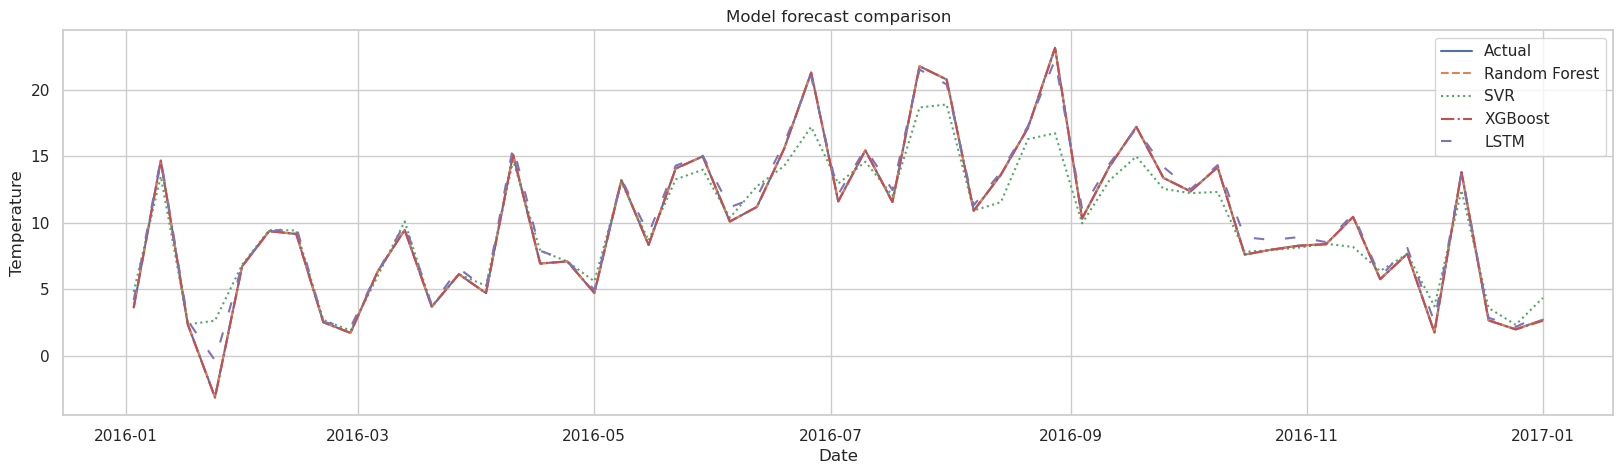

In [17]:
rf_preds = pd.Series(rf_model.predict(test_df[feature_columns]), index=test_df.index)
svr_preds = pd.Series(svr_model.predict(test_df[feature_columns]), index=test_df.index)
xgb_preds = pd.Series(xgb_model.predict(test_df[feature_columns]), index=test_df.index)
lstm_preds = pd.Series(lstm_model.predict(test_df[feature_columns].values.reshape(-1, 1, len(feature_columns))).reshape(-1), index=test_df.index)

_, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=test_df[target_column].resample(rule='W').mean(), ax=ax, label='Actual')
sns.lineplot(data=rf_preds.resample(rule='W').mean(), linestyle='dashed', ax=ax, label='Random Forest')
sns.lineplot(data=svr_preds.resample(rule='W').mean(), linestyle='dotted', ax=ax, label='SVR')
sns.lineplot(data=xgb_preds.resample(rule='W').mean(), linestyle='dashdot', ax=ax, label='XGBoost')
sns.lineplot(data=lstm_preds.resample(rule='W').mean(), linestyle=(0, (5, 10)), ax=ax, label='LSTM')
ax.set_title('Model forecast comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

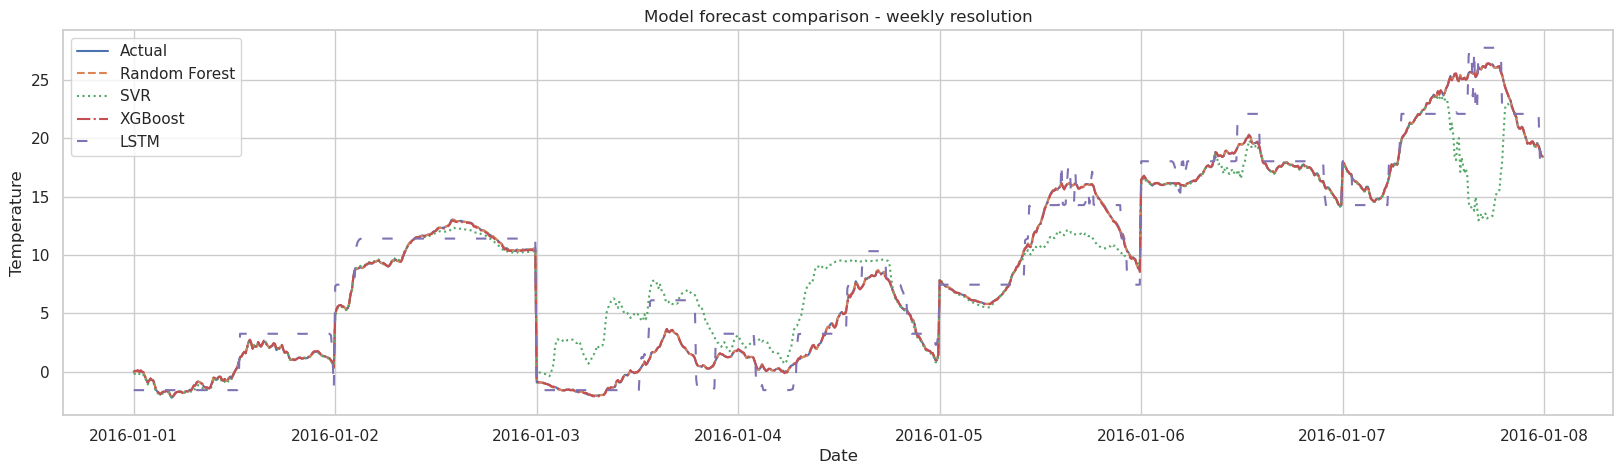

In [18]:
_, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=test_df.loc['2016-01-01':'2016-01-07'][target_column], ax=ax, label='Actual')
sns.lineplot(data=rf_preds.loc['2016-01-01':'2016-01-07'], linestyle='dashed', ax=ax, label='Random Forest')
sns.lineplot(data=svr_preds.loc['2016-01-01':'2016-01-07'], linestyle='dotted', ax=ax, label='SVR')
sns.lineplot(data=xgb_preds.loc['2016-01-01':'2016-01-07'], linestyle='dashdot', ax=ax, label='XGBoost')
sns.lineplot(data=lstm_preds.loc['2016-01-01':'2016-01-07'], linestyle=(0, (5, 10)), ax=ax, label='LSTM')
ax.set_title('Model forecast comparison - weekly resolution')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()


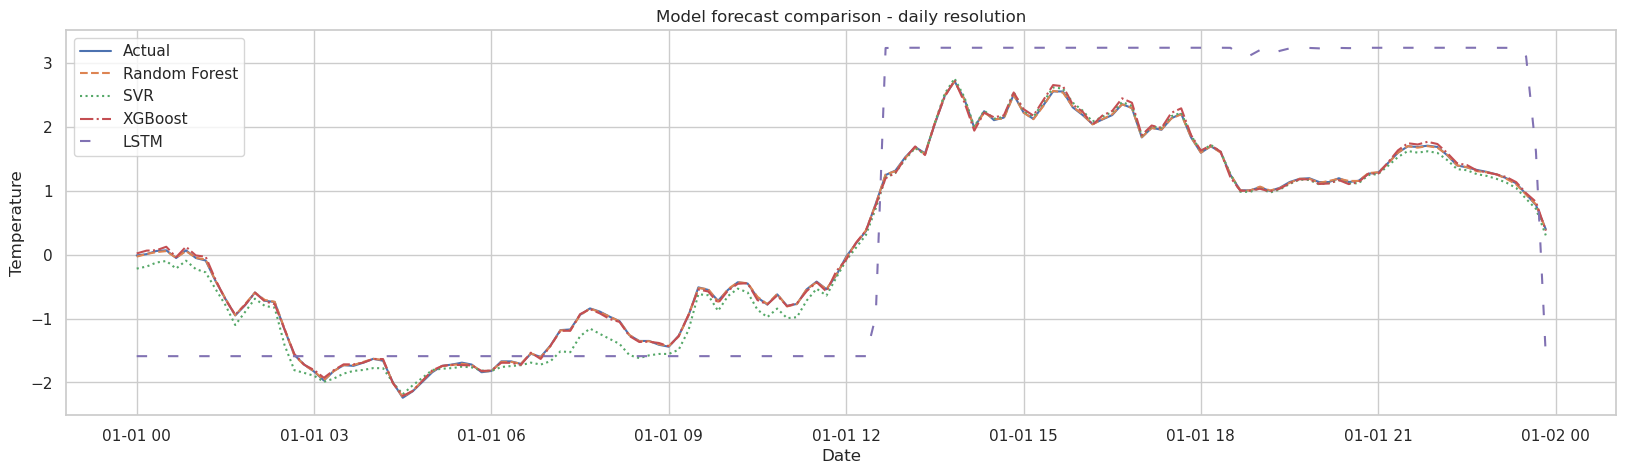

In [19]:
_, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=test_df.loc['2016-01-01':'2016-01-01'][target_column], ax=ax, label='Actual')
sns.lineplot(data=rf_preds.loc['2016-01-01':'2016-01-01'], linestyle='dashed', ax=ax, label='Random Forest')
sns.lineplot(data=svr_preds.loc['2016-01-01':'2016-01-01'], linestyle='dotted', ax=ax, label='SVR')
sns.lineplot(data=xgb_preds.loc['2016-01-01':'2016-01-01'], linestyle='dashdot', ax=ax, label='XGBoost')
sns.lineplot(data=lstm_preds.loc['2016-01-01':'2016-01-01'], linestyle=(0, (5, 10)), ax=ax, label='LSTM')
ax.set_title('Model forecast comparison - daily resolution')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

In [20]:
mae_df = pd.DataFrame({
    'Random Forest': (test_df[target_column] - rf_preds).abs().mean(),
    'SVR': (test_df[target_column] - svr_preds).abs().mean(),
    'XGBoost': (test_df[target_column] - xgb_preds).abs().mean(),
    'LSTM': (test_df[target_column] - lstm_preds).abs().mean(),
}, index=['MAE']).T

mae_df

,MAE
Random Forest,0.004522
SVR,1.437807
XGBoost,0.037006
LSTM,1.287282
